In [187]:
import glob
import itertools
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch as tc
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import numba
from tqdm import tqdm
from tqdm import trange

warnings.filterwarnings(action='ignore')


In [188]:
def get_dataframe_from_dir(path, ext, ignore_idx=False, save_file=False):
    df = pd.DataFrame()
    if ext != 'csv':
        return df
    
    csv_files = glob.glob(path + f"/*.{ext}")
    df_list = (pd.read_csv(file) for file in csv_files)
    get_next = peek(df_list)

    if get_next is None:
        print("***** empty dataframe *****")
        return df
    
    df = pd.concat(df_list, ignore_index=ignore_idx)
    if save_file:
        df.to_csv('merged.csv')
    if 'time' in df.columns:
        df.set_index("time", drop=True, append=False, inplace=True)
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    else:
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    
    return df

In [189]:
def peek(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first, itertools.chain([first], iterable)

In [190]:
def build_model(n_est=100, crt="squared_error", max_depth=None, max_leaf_nodes=None, bs=True, oob_score=False, n_jobs=None, rs=None, max_samples=None):
    model = RandomForestRegressor(
        n_estimators=n_est,
        criterion=crt,
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        bootstrap=bs,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=rs,
        max_samples=max_samples
    )
    return model


In [191]:
df = get_dataframe_from_dir("data/xaiops_metric/was/214(04.01~07.10)", "csv", save_file=True)
# df = df.sample(frac=0.01)

# remove low variance column
for column in df.columns:
    if df[column].mean() == 0:
        df.drop(columns=[column], inplace=True)

# remove rows having NaN value
df.dropna(axis=0, inplace=True)

# sort index
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143908 entries, 2022-04-01 00:00:00 to 2022-07-10 23:59:00
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   active_db_conn_count  143908 non-null  float64
 1   active_tx_count       143908 non-null  float64
 2   active_users          143908 non-null  float64
 3   call_count            143908 non-null  float64
 4   cpu_time              143908 non-null  float64
 5   cpu_usage             143908 non-null  float64
 6   db_sessions           143908 non-null  float64
 7   fetch_count           143908 non-null  float64
 8   fgc                   143908 non-null  float64
 9   fgct                  143908 non-null  float64
 10  file_count            143908 non-null  float64
 11  gc_count              143908 non-null  float64
 12  gc_time               143908 non-null  float64
 13  heap_usage            143908 non-null  float64
 14  jvm_free_heap         1439

In [192]:
df.describe()

,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct
count,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,...,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000
mean,0.348671,6.116735,1.123234,10.235244,2.639522,1.714815,8.978568,28.625452,0.008777,1.226144,...,63.995737,199.173090,63.995737,694.231591,1.031402,9.384380,143.778884,9.979260,1.022626,8.158237
std,0.855621,35.363078,0.432208,8.803050,3.062439,1.482093,0.332399,25.889013,0.019025,2.671285,...,56.854849,797.986026,56.854849,1233.171588,0.670284,6.831776,42.934727,8.751367,0.663397,5.422465
min,0.000000,0.000000,0.000000,0.000000,0.144000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.600000,0.000000,0.000000,0.000000
25%,0.000000,0.150000,0.800000,2.650000,0.483000,0.300000,9.000000,6.100000,0.000000,0.000000,...,13.650000,29.284600,13.650000,85.450000,0.350000,2.450000,119.950000,2.449900,0.300000,2.350000
50%,0.100000,0.550000,1.200000,8.950000,0.900500,1.600000,9.000000,24.500000,0.000000,0.000000,...,55.200000,35.963400,55.200000,292.000000,1.150000,10.050000,142.000000,8.666600,1.150000,9.400000
75%,0.300000,2.000000,1.450000,14.900000,4.475000,2.650000,9.000000,42.150000,0.000000,0.000000,...,94.650000,64.528375,94.650000,760.512500,1.600000,14.050000,155.450000,14.600000,1.600000,13.000000
max,8.700000,300.000000,2.100000,57.100000,14.845000,11.550000,9.800000,217.950000,0.166667,24.333333,...,315.250000,141017.833300,315.250000,79966.600000,14.833300,154.500000,406.000000,48.699900,14.666667,130.166667


In [193]:
df.index

Index(['2022-04-01 00:00:00', '2022-04-01 00:01:00', '2022-04-01 00:02:00',
       '2022-04-01 00:03:00', '2022-04-01 00:04:00', '2022-04-01 00:05:00',
       '2022-04-01 00:06:00', '2022-04-01 00:07:00', '2022-04-01 00:08:00',
       '2022-04-01 00:09:00',
       ...
       '2022-07-10 23:50:00', '2022-07-10 23:51:00', '2022-07-10 23:52:00',
       '2022-07-10 23:53:00', '2022-07-10 23:54:00', '2022-07-10 23:55:00',
       '2022-07-10 23:56:00', '2022-07-10 23:57:00', '2022-07-10 23:58:00',
       '2022-07-10 23:59:00'],
      dtype='object', name='time', length=143908)

In [194]:
df.tail(3)

,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct
time,,,,,,,,,,,,,,,,,,,,,
2022-07-10 23:57:00,0.05,2.05,0.60,1.25,2.9049,0.00,9.0,3.30,0.0,0.0,...,7.45,63.0294,7.45,152.55,0.30,1.50,148.5,1.1333,0.30,1.50
2022-07-10 23:58:00,0.00,2.00,0.65,1.25,2.0949,0.00,9.0,3.20,0.0,0.0,...,7.35,78.4626,7.35,201.00,0.25,1.25,148.5,1.1166,0.25,1.25
2022-07-10 23:59:00,0.05,2.15,0.55,1.45,2.3750,0.15,9.0,3.75,0.0,0.0,...,8.30,50.5974,8.30,119.30,0.35,2.15,148.5,1.2833,0.35,2.15


In [195]:
def get_train_test_data(df, target, ratio=0.3, random_state=1):
    if target not in df.columns:
        print(f'{target} column is not exits')
        return None, None, None, None

    X = df.loc[:, df.columns != target]
    y = df[target]
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=ratio, random_state=random_state)

    X_train.sort_index(inplace=True)
    X_test.sort_index(inplace=True)
    y_train.sort_index(inplace=True)
    y_test.sort_index(inplace=True)

    return X_train, X_test, y_train, y_test


In [196]:
df_dict = {}
for column in tqdm(df.columns):
    df_dict[column] = get_train_test_data(df, column)
    
# df_sql_time = df_dict['sql_time']
# df_sql_time[3]

100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


In [197]:
# get feature importances & scores
def get_result(model, X, y, sample_weight=None):
    result_dict = {}
    f_i = model.feature_importances_
    f_names = model.feature_names_in_
    for i, name in enumerate(f_names):
        result_dict[name] = np.round(f_i[i], 5)
    return dict(sorted(result_dict.items(), key=lambda item: item[1])), np.round(model.score(X, y), 3)


In [198]:
# build model & save it with result(feature importances, scores)
progress_cnt = 0
result_dict = {}
for key in df_dict.keys():
    print(f'{progress_cnt + 1} of {len(df_dict.keys())} ... ')
    print('key:', key, 'shapes:', df_dict[key][0].shape, df_dict[key][2].shape)
    model = build_model(n_jobs=10, rs=1)
    model.fit(df_dict[key][0], df_dict[key][2])
    
    (x_, y_) = df_dict[key][1], df_dict[key][3]
    tmp = {key: {'model': model, 'result': get_result(model, x_, y_)}}
    result_dict.update(tmp)    
    progress_cnt += 1


1 of 32 ... 
key: active_db_conn_count shapes: (100735, 31) (100735,)
2 of 32 ... 
key: active_tx_count shapes: (100735, 31) (100735,)
3 of 32 ... 
key: active_users shapes: (100735, 31) (100735,)
4 of 32 ... 
key: call_count shapes: (100735, 31) (100735,)
5 of 32 ... 
key: cpu_time shapes: (100735, 31) (100735,)
6 of 32 ... 
key: cpu_usage shapes: (100735, 31) (100735,)
7 of 32 ... 
key: db_sessions shapes: (100735, 31) (100735,)
8 of 32 ... 
key: fetch_count shapes: (100735, 31) (100735,)
9 of 32 ... 
key: fgc shapes: (100735, 31) (100735,)
10 of 32 ... 
key: fgct shapes: (100735, 31) (100735,)
11 of 32 ... 
key: file_count shapes: (100735, 31) (100735,)
12 of 32 ... 
key: gc_count shapes: (100735, 31) (100735,)
13 of 32 ... 
key: gc_time shapes: (100735, 31) (100735,)
14 of 32 ... 
key: heap_usage shapes: (100735, 31) (100735,)
15 of 32 ... 
key: jvm_free_heap shapes: (100735, 31) (100735,)
16 of 32 ... 
key: jvm_heap_size shapes: (100735, 31) (100735,)
17 of 32 ... 
key: jvm_mem_si

In [200]:
names_list = []
values_list = []
target_list = []

for key in result_dict.keys():
    print(f'target is {key}')
    target_list.append(key)

    f_i = result_dict[key]['result'][0]
    f_i = dict(sorted(f_i.items(), key=lambda f_i: f_i[0]))
#     f_i_sliced = dict(itertools.islice(f_i.items(), 5))
#     print(f_i_sliced)
    
    names = list(map(lambda k: k, f_i.keys()))
    values = list(map(lambda v: v, f_i.values()))

    names_list.append(names)
    values_list.append(values)
    
    str = ''
    for i in range(0, len(names)):
        str += f"{names[i]}={values[i]}, "
    
    print(str)
    
    print(f"score = {result_dict[key]['result'][1]}")
    print()
    

target is active_db_conn_count
active_tx_count=0.64454, active_users=0.00078, call_count=0.00062, cpu_time=0.00153, cpu_usage=0.0008, db_sessions=0.00054, fetch_count=0.00091, fgc=2e-05, fgct=0.00027, file_count=0.03223, gc_count=0.00033, gc_time=0.00054, heap_usage=0.0005, jvm_free_heap=0.00099, jvm_heap_size=0.00066, jvm_mem_size=0.00124, jvm_used_heap=0.00053, os_free_memory=0.00142, os_rcv_packets=0.00085, os_send_packets=0.00088, os_total_memory=0.0, prepare_count=0.00041, response_time=0.00178, sql_count=0.00045, sql_time=0.21695, tgc=0.00034, tgct=0.00056, thread_count=0.08757, tps=0.00061, ygc=0.00034, ygct=0.0008, 
score = 0.982

target is active_tx_count
active_db_conn_count=0.00341, active_users=0.00226, call_count=0.00308, cpu_time=0.00024, cpu_usage=3e-05, db_sessions=0.0, fetch_count=9e-05, fgc=0.0, fgct=1e-05, file_count=2e-05, gc_count=3e-05, gc_time=2e-05, heap_usage=3e-05, jvm_free_heap=3e-05, jvm_heap_size=0.00018, jvm_mem_size=0.00026, jvm_used_heap=3e-05, os_free_m

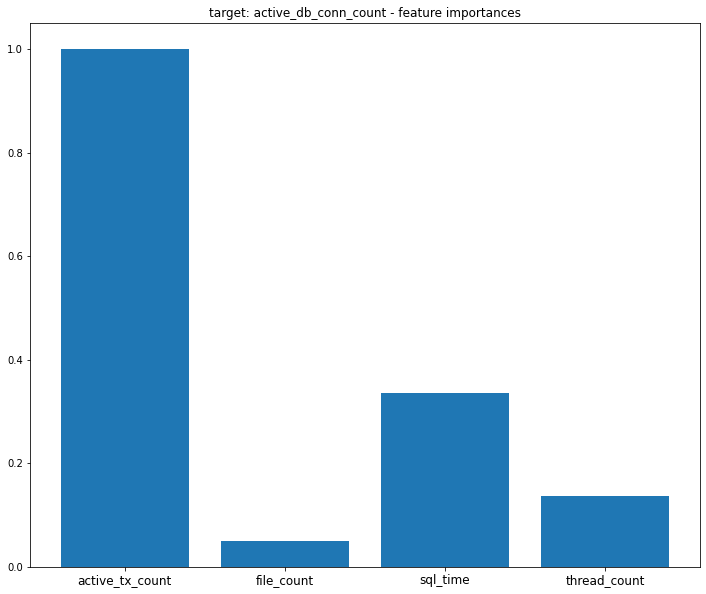

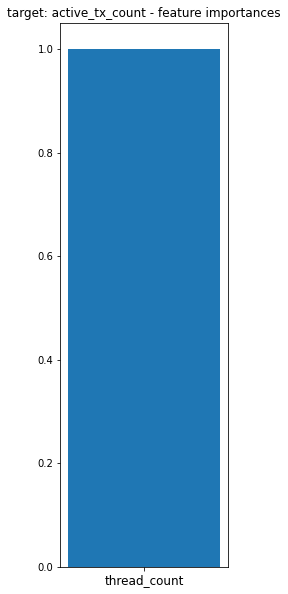

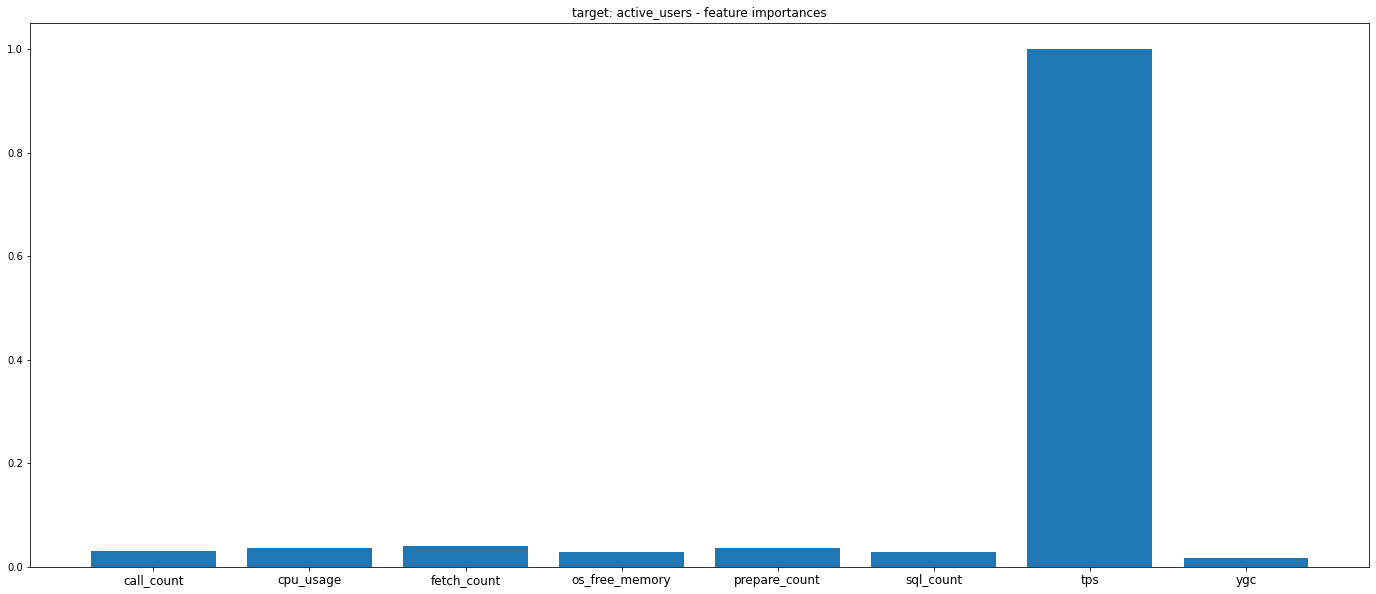

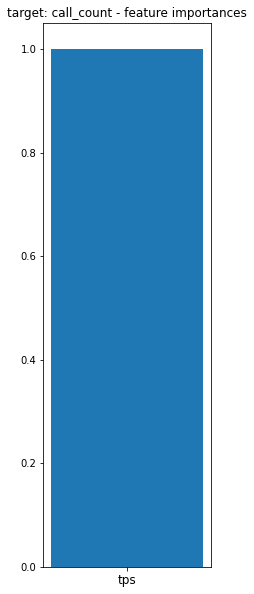

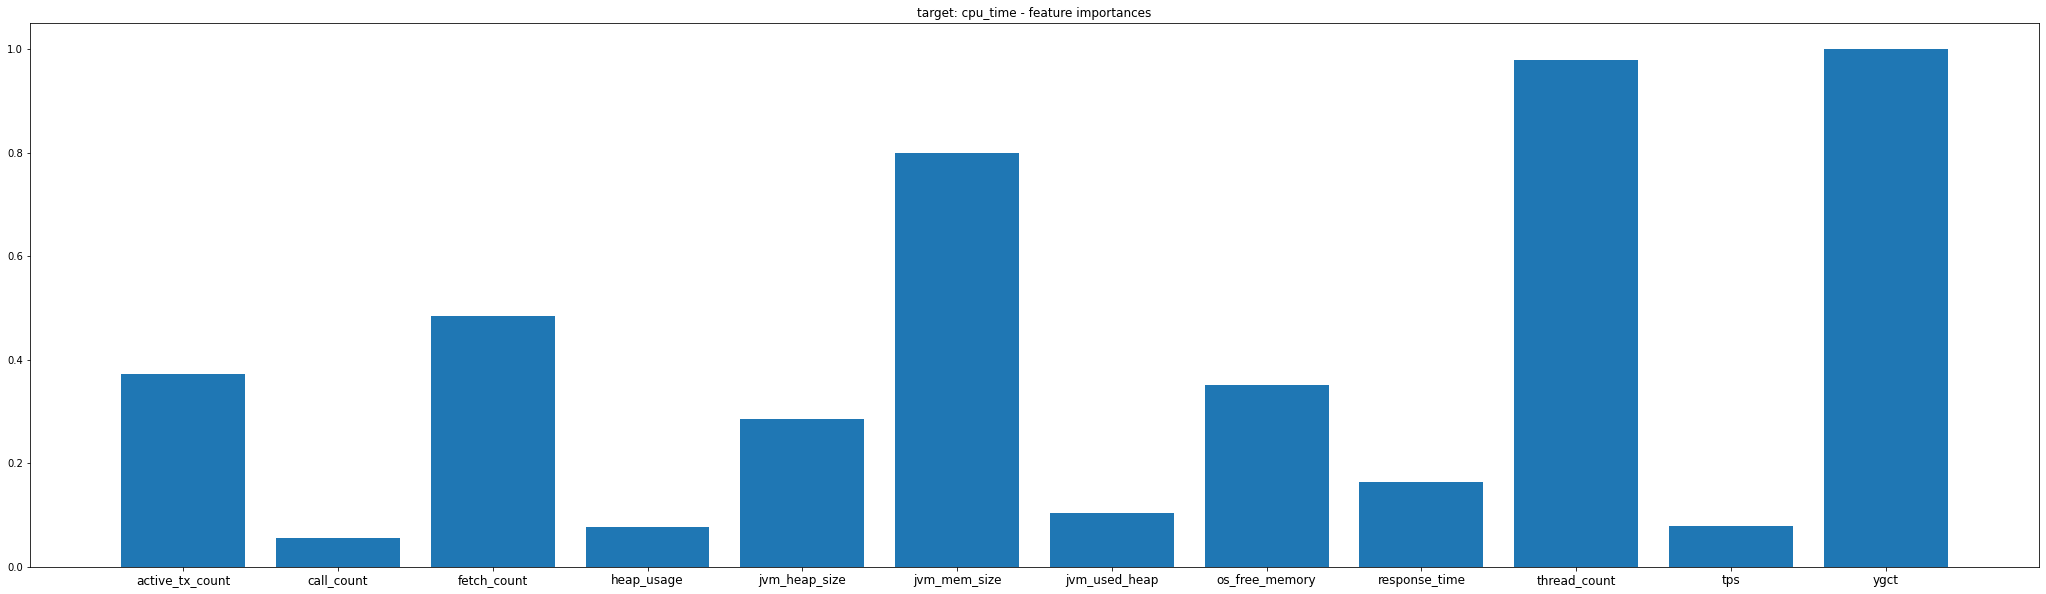

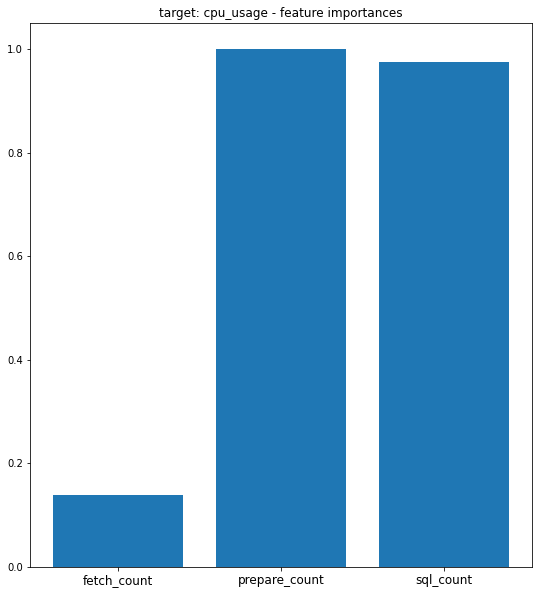

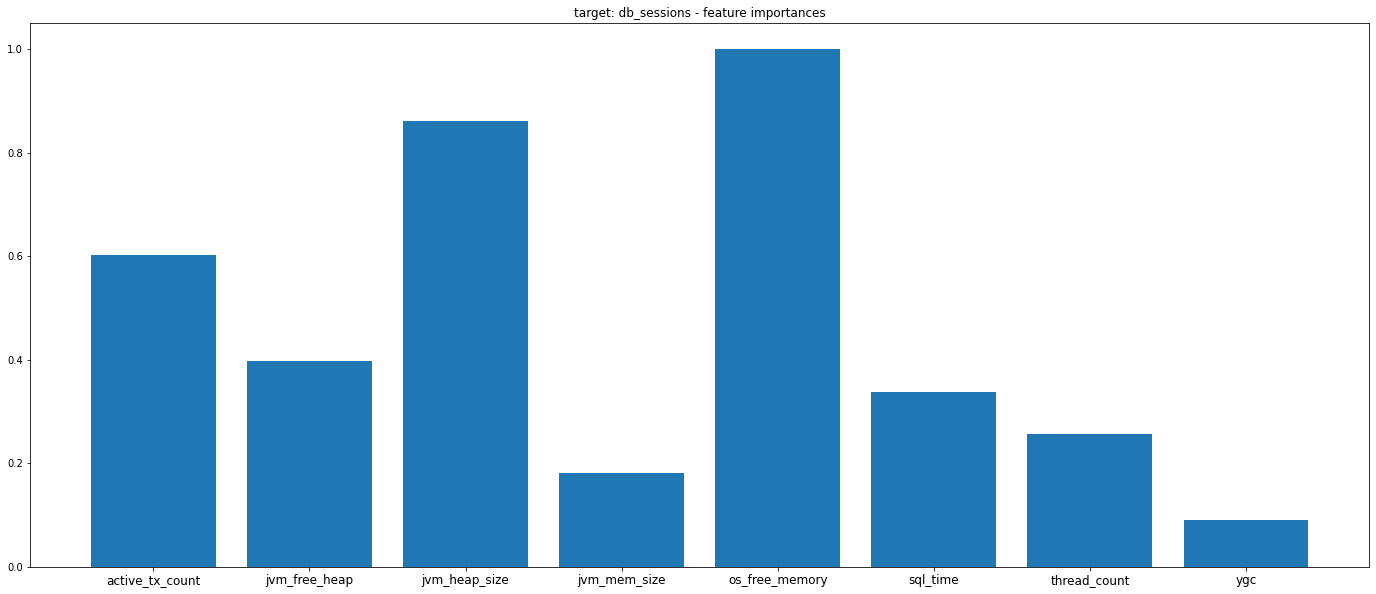

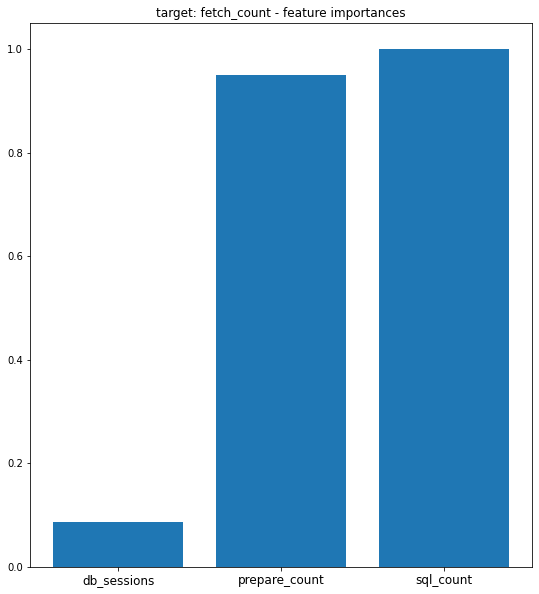

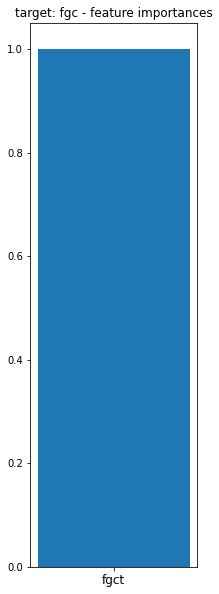

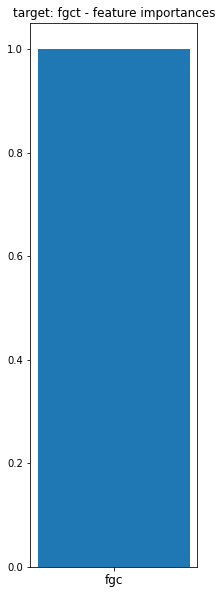

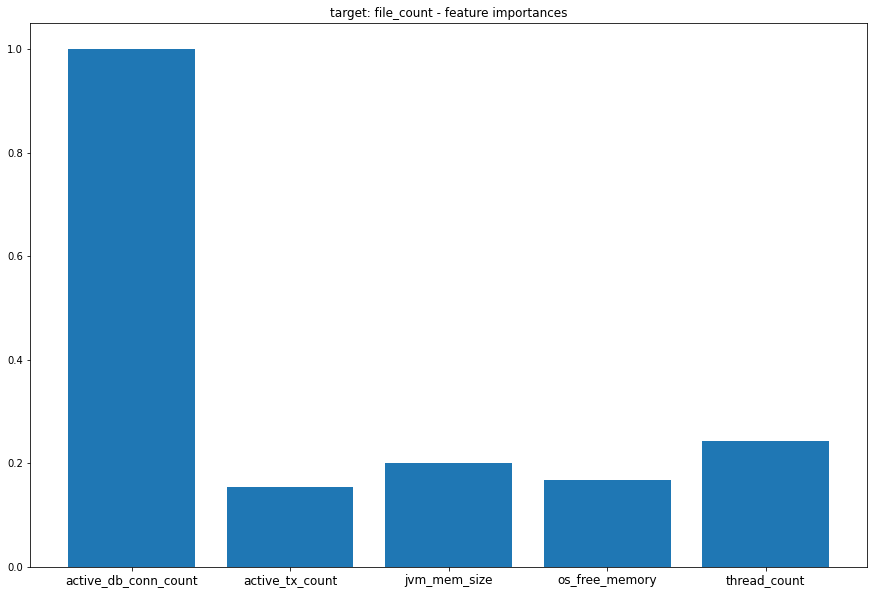

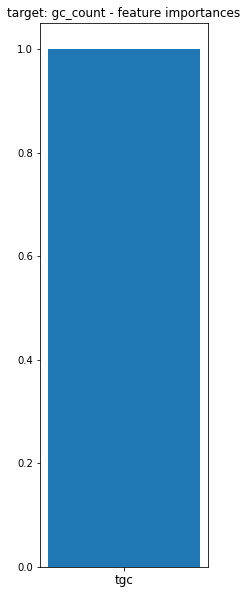

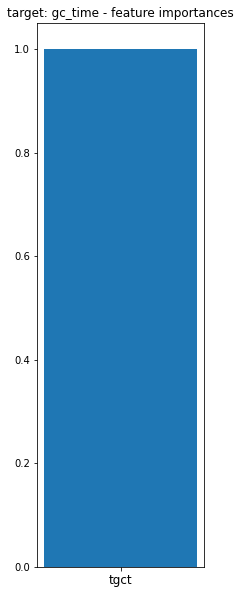

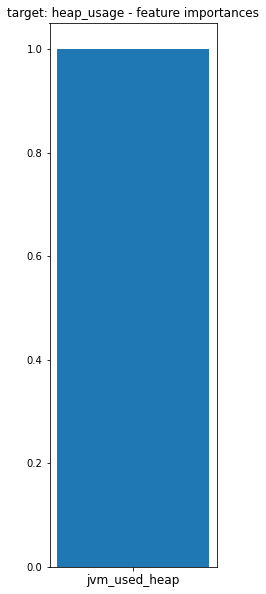

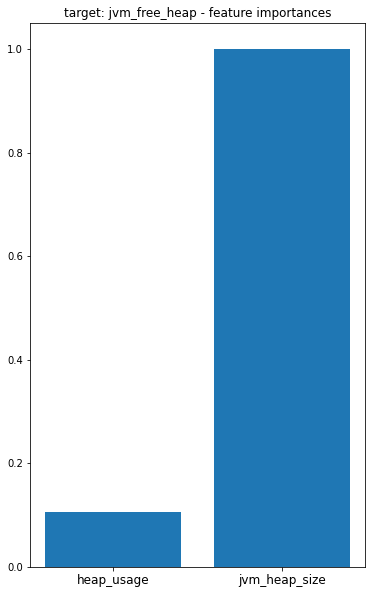

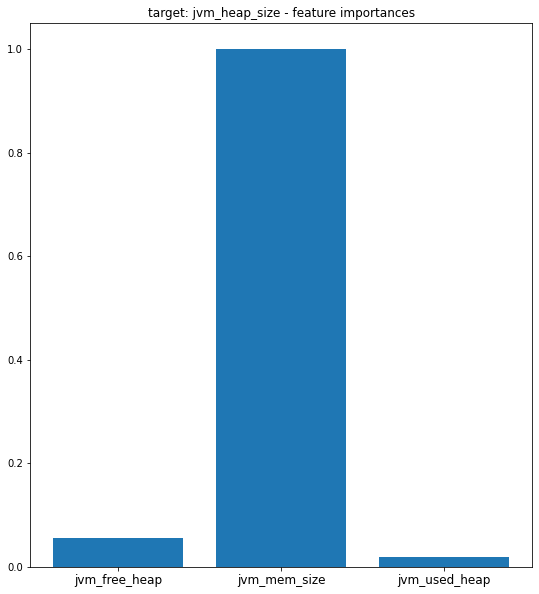

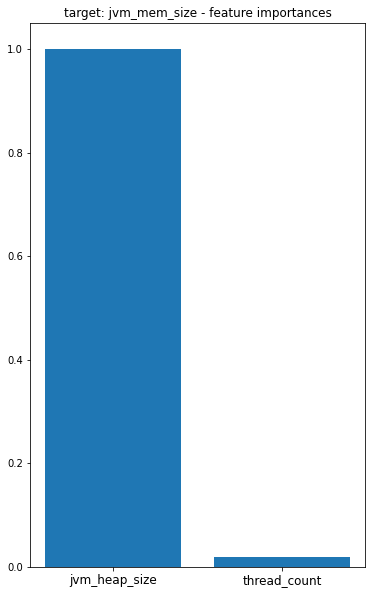

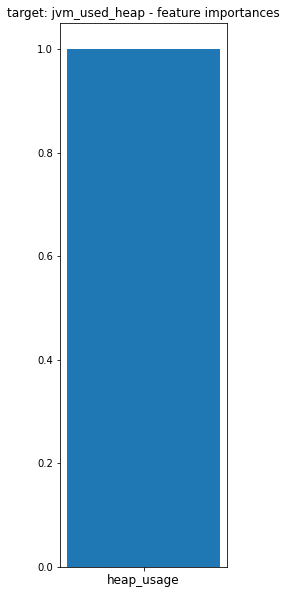

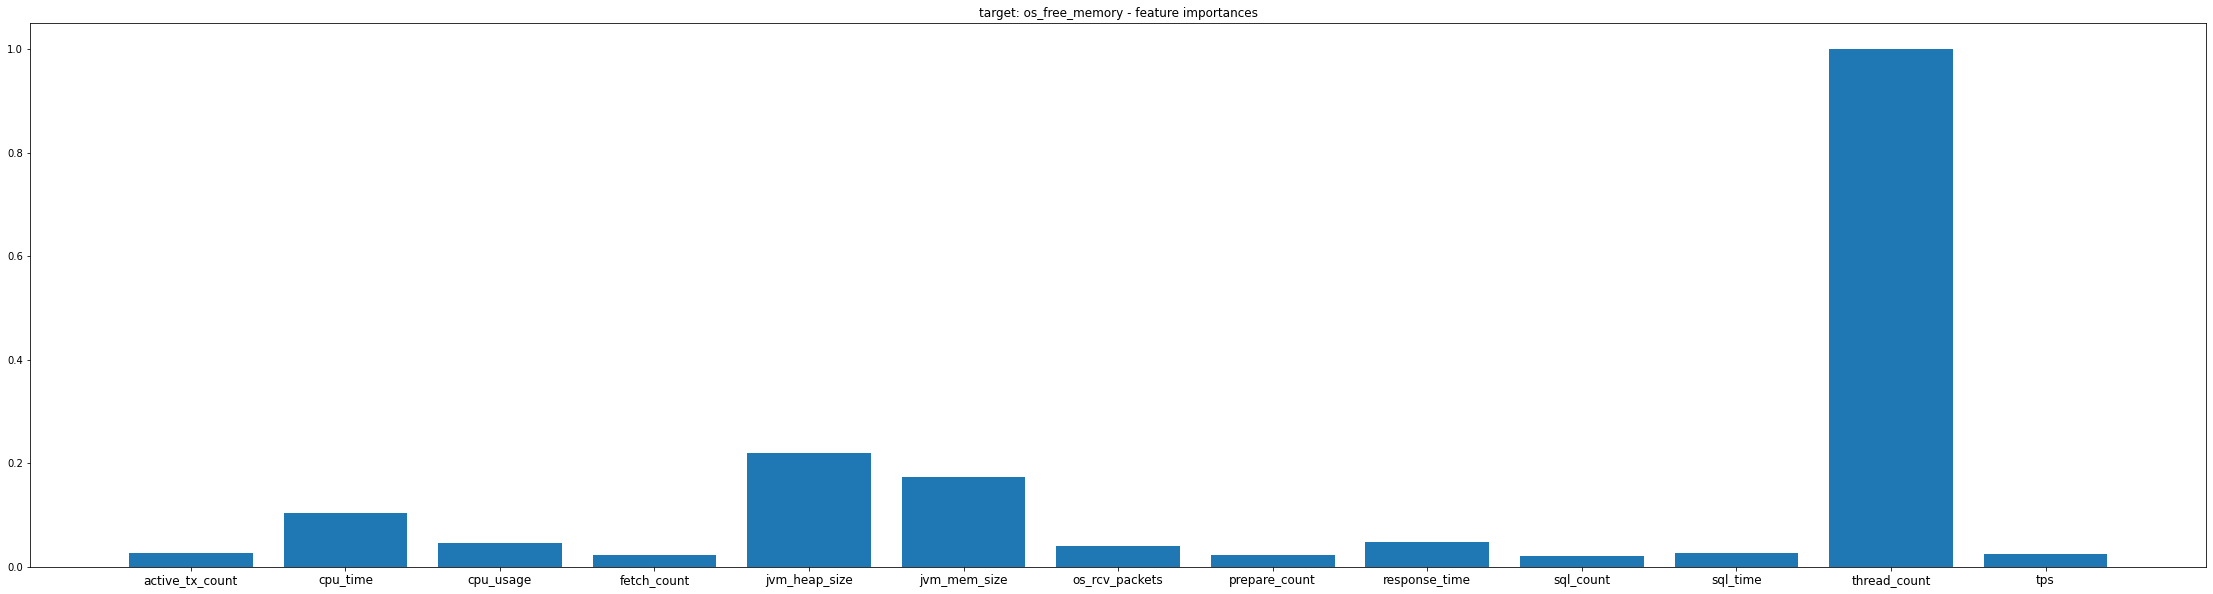

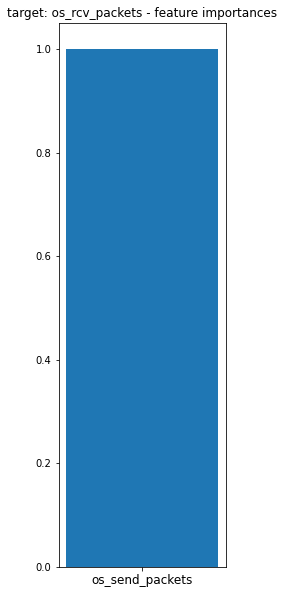

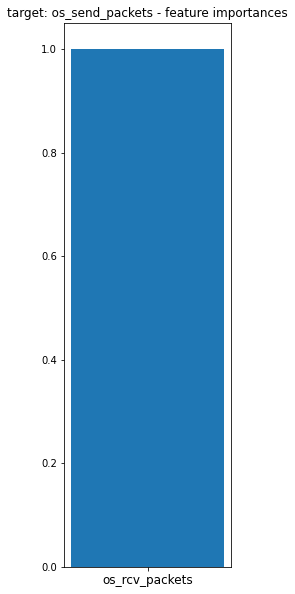

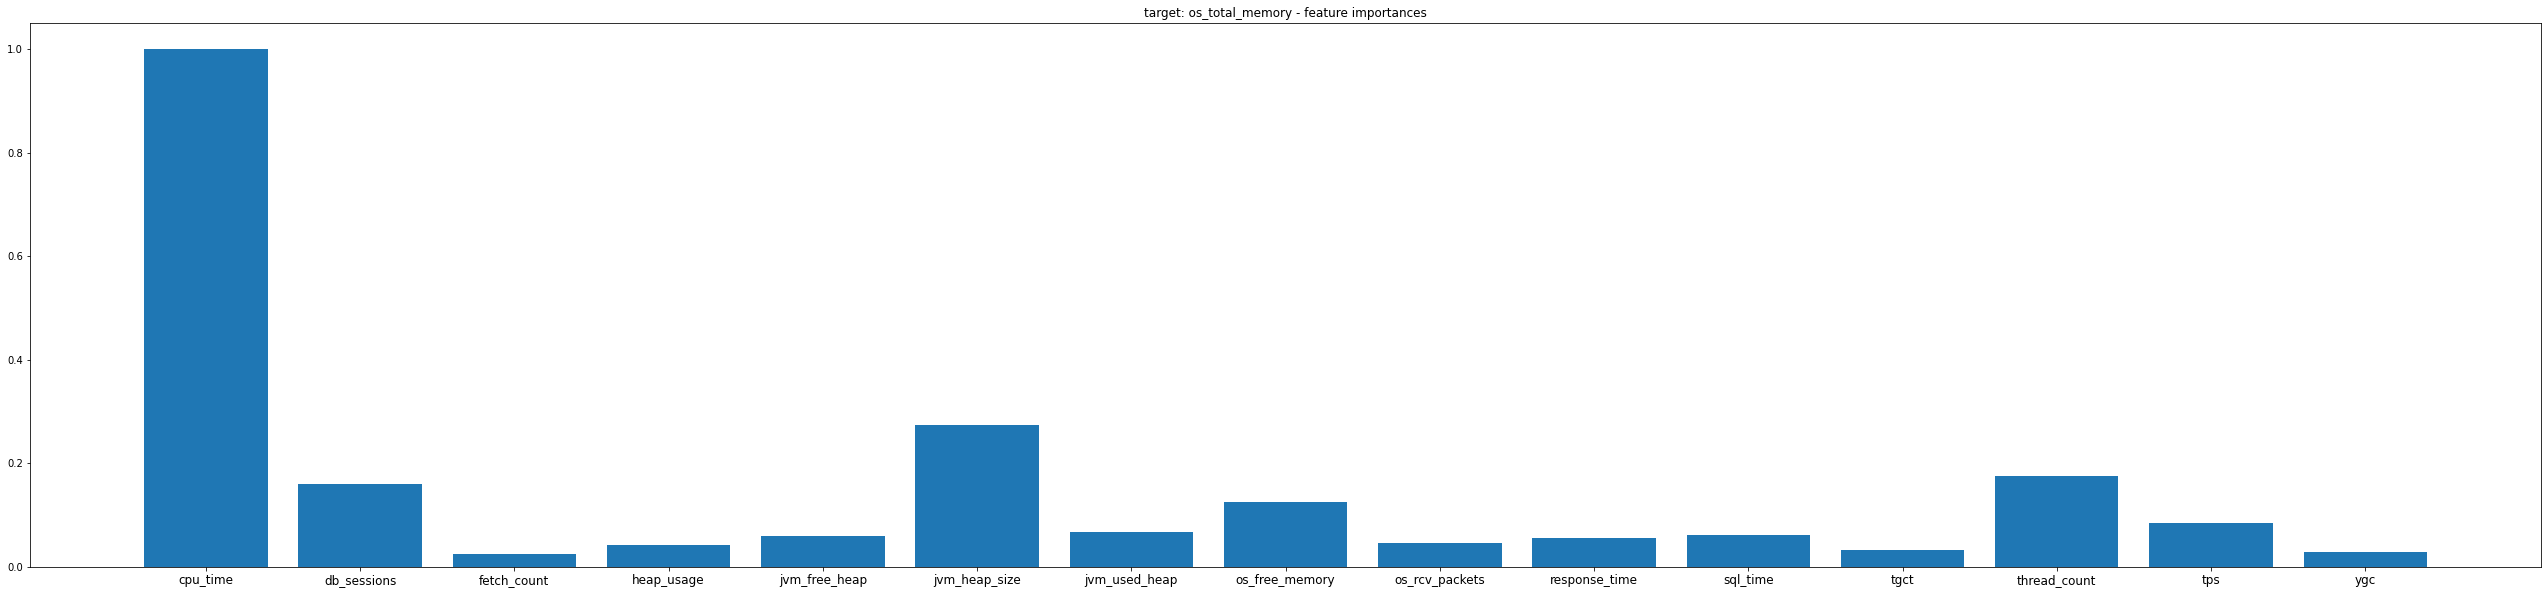

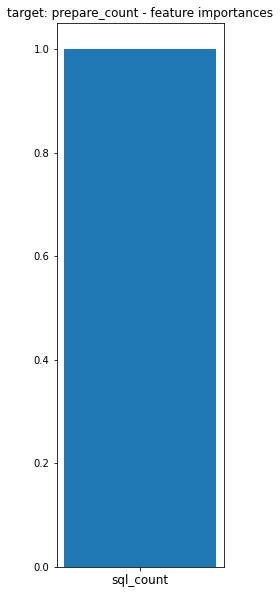

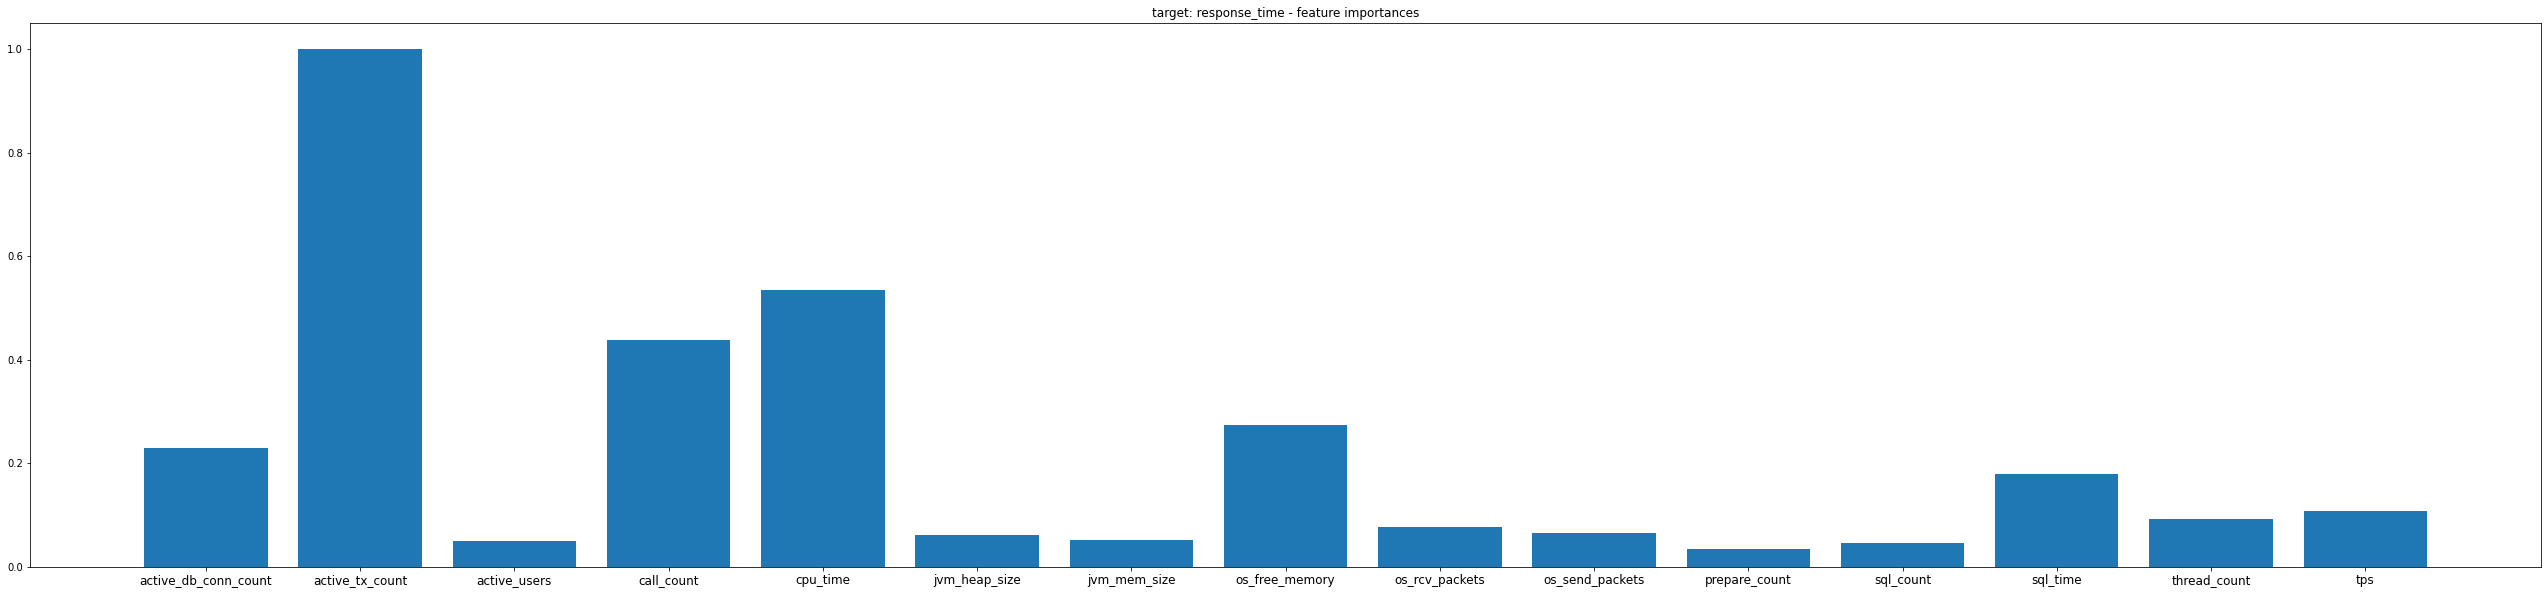

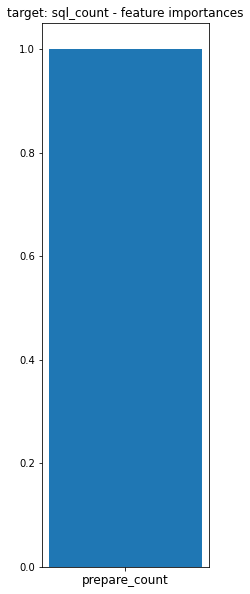

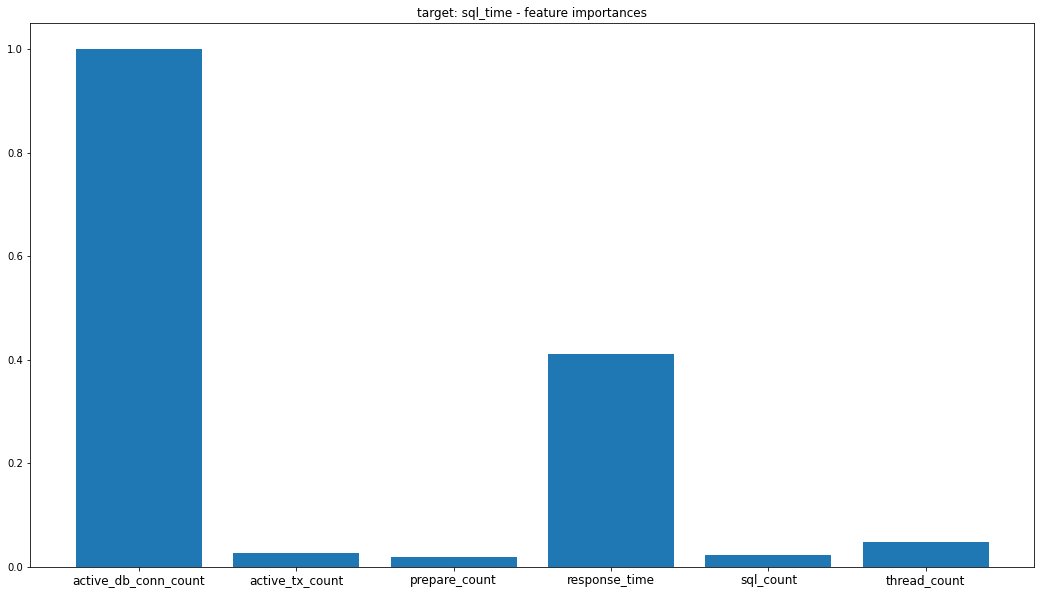

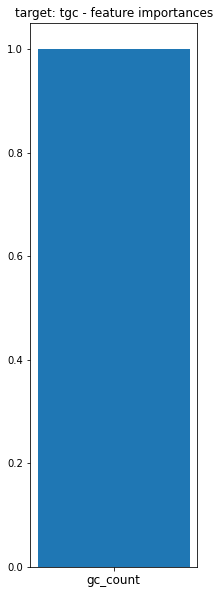

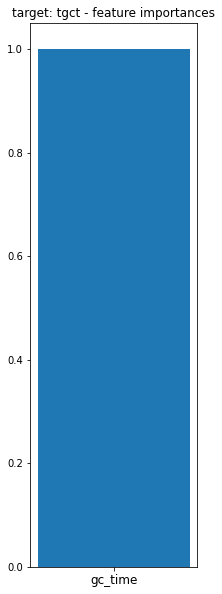

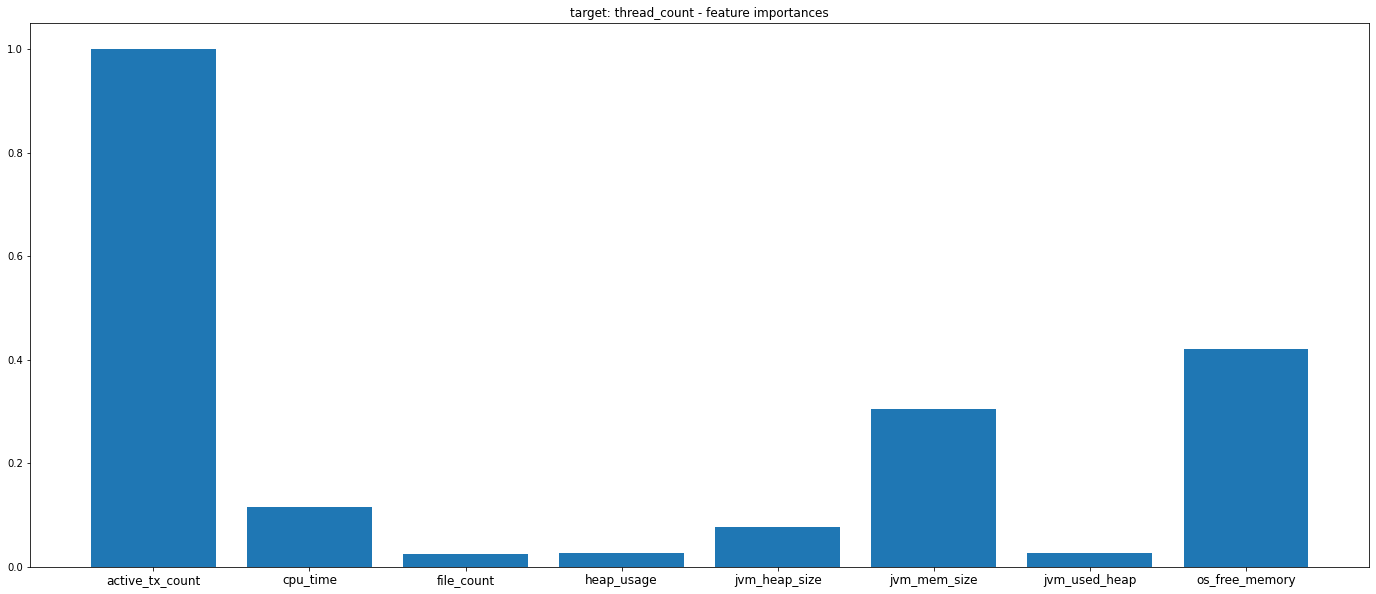

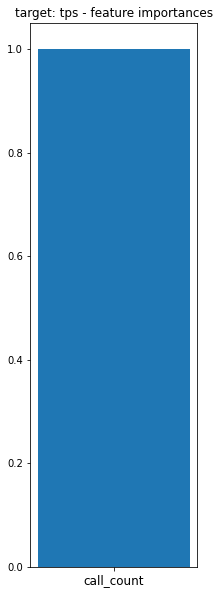

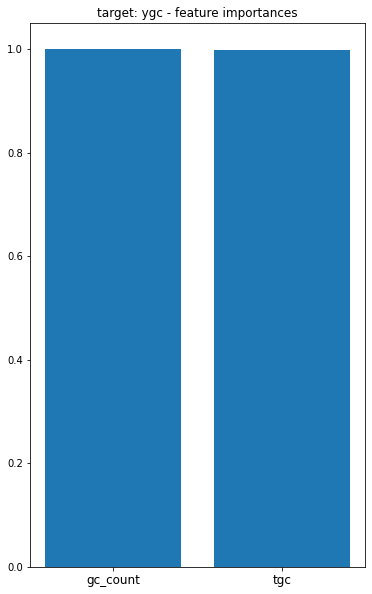

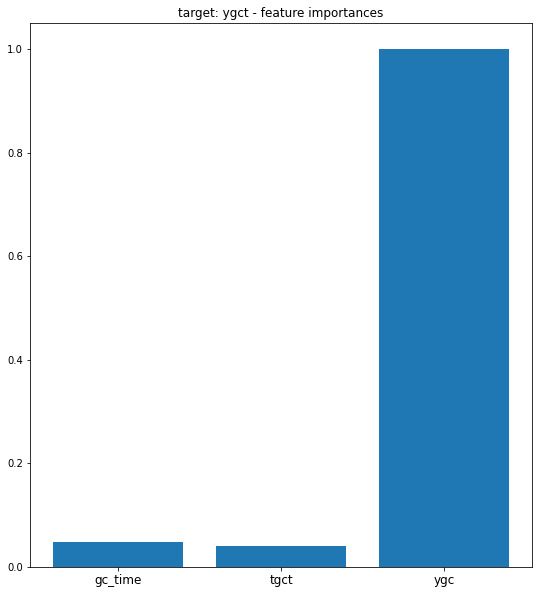

In [213]:
# visualize feature importances
for i in range(len(names_list)):
    feature_names = names_list[i]
    importances = values_list[i]
    target = target_list[i]
    
    for i, value in enumerate(importances):
        if value < 0.01:
            del feature_names[i]
            del importances[i]

    max_i = max(importances)
    importances = list(map(lambda importance: importance/max_i, importances))
    
    plt.figure(figsize=(3*len(feature_names), 10))
    plt.bar(np.arange(0, len(importances)), importances)
    plt.xticks(np.arange(0, len(importances)), feature_names, fontsize=12)
    plt.title(f'target: {target} - feature importances', fontsize=12)
    plt.show()
